In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# input files/dir
DRIVER_GENES = f"../data/driver_genes"
GENE_ANNOT = f"../data/ref/gencode.v19.annotation.gtf"
MUTATION_DATA = f"../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"

# output files/dir
RESULTS = f"../results/passenger_distribution_tss_tes"

if not os.path.exists(RESULTS):
	os.system(f"mkdir -p {RESULTS}")

CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types that have driver gene data
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

BIN_COUNT = 100
UPSTREAM_DOWNSTREAM = 10

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [4]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [5]:
gene_annot = pd.read_csv(GENE_ANNOT, sep="\t", header=None, comment="#")

In [ ]:
mut_bins_mean_counts = []
genome_wide_mut_df = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
for cancer_type in CANCER_TYPES:
	print(cancer_type)
	mut_cancer_df = pd.read_csv(f"{MUTATION_DATA}/{cancer_type}.tsv", sep="\t")
	# filter out samples that are not in the whitelist
	mut_cancer_df = mut_cancer_df[mut_cancer_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
	genome_wide_mut_cancer_df = genome_wide_mut_df[genome_wide_mut_df["cancer_type"] == cancer_type] # filter mutations in the cancer type
	mut_cancer_df = pd.merge(mut_cancer_df, genome_wide_mut_cancer_df, on=["Tumor_Sample_Barcode"], how="left") # merge with genome wide mutations

	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes = driver_genes[["gene", "chr", "gene_start", "gene_end", "strand"]]

	gene_tss_tes = {}
	# get the first TSS and last TES for each driver gene
	for index, row in driver_genes.iterrows():
		gene = row["gene"]
		gene_annotation = gene_annot[gene_annot[8].str.contains(f'gene_name "{gene}"')]
		transcripts = gene_annotation[gene_annotation[2] == "transcript"]
		transcripts = transcripts[[0, 3, 4]]
		transcripts.drop_duplicates(subset=[0, 3, 4], keep="first", inplace=True)
		tss = min(transcripts[3].values)
		tes = max(transcripts[4].values)
		gene_tss_tes[gene] = {
			"tss": tss,
			"tes": tes
		}

	# sampling with replacement 
	for _ in range(100):  # repeat the sampling 100 times to get a distribution
		mut_cancer_df_sampled = mut_cancer_df.sample(frac=0.8, replace=True).reset_index(drop=True)  # shuffle the data

		mut_bin_with_driver = []
		mut_bin_without_driver = []

		for index, row in driver_genes.iterrows():
			gene = row["gene"]
			strand = row["strand"]
			gene_length = row["gene_end"] - row["gene_start"] + 1
			tss = gene_tss_tes[gene]["tss"]
			tes = gene_tss_tes[gene]["tes"]

			# get mutations in the driver gene
			mut_df = mut_cancer_df_sampled[mut_cancer_df_sampled["gene"] == gene] # filter mutations in the gene

			# patient data
			total_patients = len(mut_df["Patient_ID"].unique())
			donors_with_driver = list(mut_df[mut_df["has_driver"] == True]["Patient_ID"].unique())

			# get passenger mutations in the gene in groups of samples with and without driver mutations
			mut_passenger_df = mut_df[~mut_df["driver"]] # get passenger mutations
			donor_passengers_df = mut_passenger_df.groupby("Patient_ID").agg({ # group by donor
								"mutation": lambda x: set(x),
								"has_driver": "any",
								"total_mutations": "first", # genome wide mutations
								"cna_burden": "first" # genome wide copy number alterations burden
							}).reset_index()
			donor_passengers_df = donor_passengers_df.explode("mutation")
			donor_passengers_df["chromosome"] = donor_passengers_df["mutation"].apply(lambda x: x.split(":")[0])
			donor_passengers_df["start"] = donor_passengers_df["mutation"].apply(lambda x: int(x.split(":")[1].split("-")[0])).astype(int)
			donor_passengers_df["end"] = donor_passengers_df["mutation"].apply(lambda x: int(x.split(":")[1].split("-")[1])).astype(int)
			donor_passengers_df = donor_passengers_df[['chromosome', 'start', 'end', 'has_driver', 'total_mutations', 'cna_burden']]
			donor_passengers_df["cna_burden"] = donor_passengers_df["cna_burden"] / 100 # convert to fraction
			# donor_passengers_df["mut_density"] = 1e9 / (donor_passengers_df["total_mutations"] * gene_length * donor_passengers_df["cna_burden"])
			donor_passengers_df["mut_density"] = 3.2e9 / (donor_passengers_df["total_mutations"] * gene_length * donor_passengers_df["cna_burden"])
			donor_with_driver = donor_passengers_df[donor_passengers_df["has_driver"]]
			donor_without_driver = donor_passengers_df[~donor_passengers_df["has_driver"]]

			# create bins of equal size for the genes
			bin_size = (tes - tss) // BIN_COUNT
			if donor_passengers_df.empty:
				start = tss
				end = tes
			else:
				start = min(tss, min(donor_passengers_df["start"]))
				end = max(tes, max(donor_passengers_df["end"]))
			bins = {}

			# get bins between TSS and TES
			for i in range(BIN_COUNT):
				bin_start = tss + (i * bin_size)
				bin_end = bin_start + bin_size
				bins[i] = (bin_start, bin_end)
			
			# get bins before TSS
			i = -1
			bin_end = tss
			while i > (-1 - UPSTREAM_DOWNSTREAM):
				bin_start = bin_end - bin_size
				bins[i] = (bin_start, bin_end)
				if bin_start <= start:
					break
				bin_end = bin_start
				i -= 1

			# get bins after TES
			i = BIN_COUNT
			bin_start = tes
			while i < (BIN_COUNT + UPSTREAM_DOWNSTREAM):
				bin_end = bin_start + bin_size
				bins[i] = (bin_start, bin_end)
				if bin_end >= end:
					break
				bin_start = bin_end
				i += 1

			# get bin counts
			bin_counts_with_driver = {}
			bin_counts_without_driver = {}
			for k, v in bins.items():
				bin_counts_with_driver[k] = donor_with_driver[(donor_with_driver["start"] >= v[0]) & (donor_with_driver["end"] < v[1])]["mut_density"].sum()
				num_patients_with_driver = len(donors_with_driver)
				if num_patients_with_driver > 0:
					# get mean mutation density per patient
					bin_counts_with_driver[k] /= num_patients_with_driver
				bin_counts_without_driver[k] = donor_without_driver[(donor_without_driver["start"] >= v[0]) & (donor_without_driver["end"] < v[1])]["mut_density"].sum()
				num_patients_without_driver = total_patients - len(donors_with_driver)
				if num_patients_without_driver > 0:
					# get mean mutation density per patient
					bin_counts_without_driver[k] /= num_patients_without_driver

			if strand == "-":
				bin_counts_with_driver_reverse = {}
				bin_counts_without_driver_reverse = {}
				# reverse upstream and downstream bins 
				# 0 will be 99, 1 will be 98, 2 will be 97, etc.
				# -1 will be 100, -2 will be 101, -3 will be 102, etc.
				# 100 will be -1, 101 will be -2, 102 will be -3, etc.
				for k, v in bins.items():
					new_k = 99 - k # bins are centred at 0 and 99
					bin_counts_with_driver_reverse[new_k] = bin_counts_with_driver[k]
					bin_counts_without_driver_reverse[new_k] = bin_counts_without_driver[k]
				bin_counts_with_driver = bin_counts_with_driver_reverse
				bin_counts_without_driver = bin_counts_without_driver_reverse

			mut_bin_with_driver.append(bin_counts_with_driver)
			mut_bin_without_driver.append(bin_counts_without_driver)

		# mean across all genes
		mean_bin_with_driver = pd.DataFrame(mut_bin_with_driver).mean().to_dict()
		mean_bin_with_driver["group"] = "with_driver"
		mean_bin_without_driver = pd.DataFrame(mut_bin_without_driver).mean().to_dict()
		mean_bin_without_driver["group"] = "without_driver"
	
		# mean counts for sampled patients
		mut_bins_mean_counts.append(mean_bin_with_driver)
		mut_bins_mean_counts.append(mean_bin_without_driver)

mut_bins_mean_counts_df = pd.DataFrame(mut_bins_mean_counts)
mut_bins_mean_counts_df.fillna(0, inplace=True)  # fill NaN values with 0
mut_bins_mean_counts_df.head()
mut_bins_mean_counts_df.to_csv(f"{RESULTS}/passenger_distribution_tss_tes.tsv", sep="\t", index=False)

CNS-Oligo
Kidney-ChRCC
Prost-AdenoCA
Kidney-RCC
Stomach-AdenoCA
CNS-Medullo
Thy-AdenoCA
Myeloid-MPN
Bone-Leiomyo
Lymph-BNHL
Myeloid-AML
Lung-AdenoCA
CNS-GBM
Head-SCC
Breast-AdenoCa
Ovary-AdenoCA
CNS-PiloAstro
Cervix-SCC
Liver-HCC
Bone-Osteosarc
Biliary-AdenoCA
Skin-Melanoma
Lung-SCC
Lymph-CLL
Panc-Endocrine
Bladder-TCC
Panc-AdenoCA
ColoRect-AdenoCA
Breast-LobularCa
Eso-AdenoCa
Uterus-AdenoCA


In [10]:
mut_bins_mean_counts_df = pd.read_csv(f"{RESULTS}/passenger_distribution_tss_tes.tsv", sep="\t")
# make all column headers integers
for col in mut_bins_mean_counts_df.columns:
	if col != "group":
		col_int = int(col)
		mut_bins_mean_counts_df.rename(columns={col: col_int}, inplace=True)
columns = mut_bins_mean_counts_df.columns.tolist()
columns.remove("group")
columns.sort()
print(columns)
mut_bins_mean_counts_df_log = mut_bins_mean_counts_df.copy()
for i in range(-10, 110):
	mut_bins_mean_counts_df_log[i] = mut_bins_mean_counts_df[i].apply(lambda x: np.log10(x+1))
mut_bins_mean_counts_df_log.head()

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]


,99,98,97,96,95,94,93,92,91,90,...,109,-2,-3,-4,-5,-6,-7,-8,-9,-10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
mut_with_driver_bins = mut_bins_mean_counts_df_log[mut_bins_mean_counts_df_log["group"] == "with_driver"].drop(columns=["group"])
mut_without_driver_bins = mut_bins_mean_counts_df_log[mut_bins_mean_counts_df_log["group"] == "without_driver"].drop(columns=["group"])

# sort columns by bin number
mut_with_driver_bins = mut_with_driver_bins.reindex(sorted(mut_with_driver_bins.columns), axis=1)
mut_without_driver_bins = mut_without_driver_bins.reindex(sorted(mut_without_driver_bins.columns), axis=1)

mut_with_driver_bins.head()

,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,...,100,101,102,103,104,105,106,107,108,109
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# create a new dataframe with columns bin_number, mean_count
mut_with_driver_bins_melted = mut_with_driver_bins.melt(var_name="bin_number", value_name="mean_count")
mut_without_driver_bins_melted = mut_without_driver_bins.melt(var_name="bin_number", value_name="mean_count")
mut_without_driver_bins_melted.head()

,bin_number,mean_count
0,-10,0.0
1,-10,0.0
2,-10,0.0
3,-10,0.0
4,-10,0.0


In [13]:
# kilmogorov-Smirnov test
from scipy.stats import ks_2samp
ks_statistic, p_value = ks_2samp(mut_with_driver_bins_melted["mean_count"], mut_without_driver_bins_melted["mean_count"])
print(f"KS Statistic: {ks_statistic}, p-value: {p_value}")

KS Statistic: 0.39773924731182797, p-value: 0.0


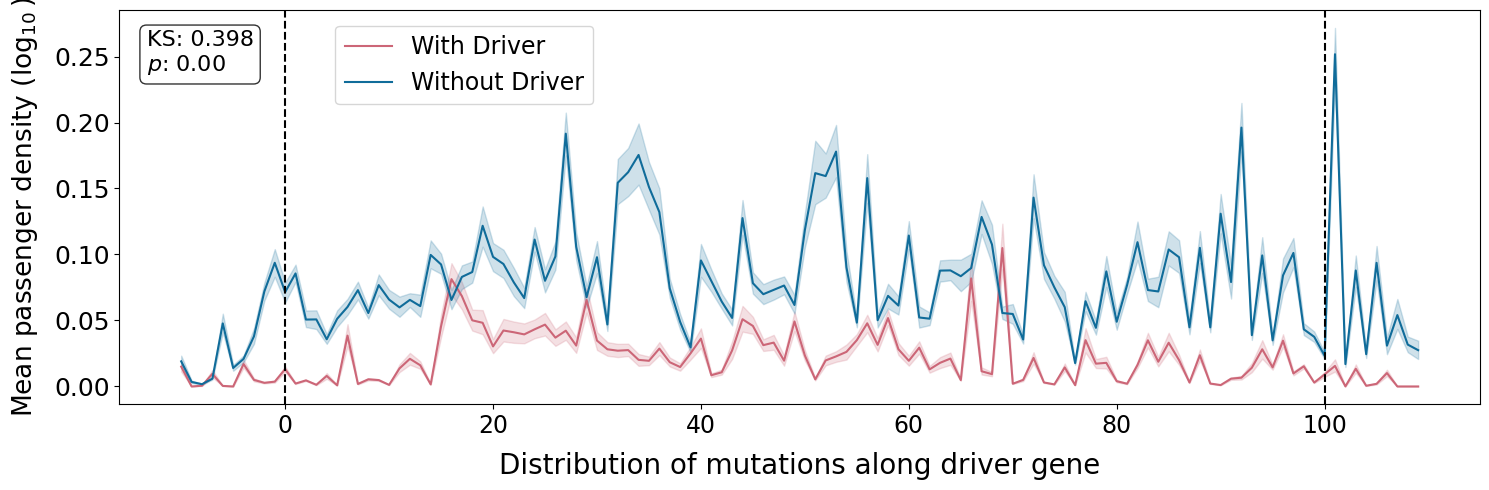

In [30]:
plt.figure(figsize=(15, 5))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
sns.lineplot(
    mut_with_driver_bins_melted, 
    x="bin_number", 
    y="mean_count", 
    errorbar=("ci", 95),
    label="With Driver", 
	color=cmap[0]
)
sns.lineplot(
    mut_without_driver_bins_melted, 
	x="bin_number", 
	y="mean_count", 
    errorbar=("ci", 95),
	label="Without Driver", 
	color=cmap[1]
)
plt.axvline(x=0, color="black", linestyle="--")
plt.axvline(x=BIN_COUNT, color="black", linestyle="--")

# add p-value annotation
plt.annotate(
    rf"KS: {ks_statistic:.3f}" + "\n" + rf"$p$: {p_value:.2f}",
	xy=(0.02, 0.95), 
	xycoords='axes fraction', 
	fontsize=16, 
	ha='left', 
	va='top',
	bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor="white", alpha=0.8)
)

plt.xticks(fontsize=17)
plt.xlabel("Distribution of mutations along driver gene", fontsize=20, labelpad=10)
plt.yticks(fontsize=18)
plt.ylabel(r"Mean passenger density ($\log_{10}$)", fontsize=19, labelpad=10)

plt.legend(fontsize=17, bbox_to_anchor=(0.15, 0.99))

plt.tight_layout()